## The Maximum Cut Problem

Reference: Hadfield, S. et al. From the Quantum Approximate Optimization Algorithm to a Quantum Alternating Operator Ansatz. Algorithms 12, 34 (2019).

**Problem** : Given a graph G = (V, E), find a subset $S \subset V$ such that the number of edgs between S and V\\S is the largest.

**Approximability** APX-complete. NP-hard to approxiamte better that 16/17 (see: _See reference above for more details._)

<img src=https://upload.wikimedia.org/wikipedia/commons/c/cf/Max-cut.svg alt="drawing" style="width:500px;"/>

In [ ]:
!pip install networkx


[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: pip install --upgrade pip


### Setting up mimiq

Let's start by iporting all the modules we will use in this notbook.

In [2]:
# Mimiq
from quantanium import *
from mimiqcircuits import *

# utils
from random import randint, seed, random
import matplotlib.pyplot as plt
import networkx as nx
from math import pi

## Graph Construction

For defining a max-cut probblem we can choose a random graph. Below you can choose a Random numer generator seed, the number of nodes and a link probability 

For more information on how to handle graph in python, have a  look at networkx

Simulations will scale with the graph size and with the number of links, For best results under the 5 minutes default time limit, keep the number of links below 20, and the probability of link activation below 0.5.

The probability formula for a link between the vertices v and u is computed according to the following formula:
$$P({u,v} \in E) = \frac{p}{|u-v|^{χ}}$$

### Prepare Graph

#### random_graph(num_nodes, p, chi[; seed = nothing])

Builds a random graph with a given number of nodes $num_nodes$ and activate links between nodes individually
 with probability $p / d^\chi$ where $d$ is the distance between the nodes.


In [3]:
def random_graph(n, p, dmax, chi=0):
    if p > 1 or p < 0:
        raise Exception("p must be between 0 and 1")

    G = nx.Graph()
    nodes = range(1, n + 1)
    edges = []
    for i in range(1, n+1):
        for j in range(i+1, n+1):
            if abs(i -j) > dmax:
                continue
            else:
                # seed(rng)
                if random() < p / abs(i-j)**chi:
                    edges.append((i, j))
    G.add_nodes_from(nodes)
    G.add_edges_from(edges)

    return G


In [4]:
c = Circuit()
c.push(GateX(), 5)
c.push(Parallel(3, GateH()), 1, 2, 3)

Quantanium().execute(c)

QCSResults:
├── simulator: Quantanium StateVector 1.0
├── timings:
│    ├── apply time: 5.3988e-05s
│    └── sample time: 0.000212388s
├── fidelity estimate: 1
├── average multi-qubit gate error estimate: 0
├── most sampled:
│    ├── bs"011001" => 142
│    ├── bs"011101" => 135
│    ├── bs"010001" => 131
│    ├── bs"000001" => 128
│    └── bs"010101" => 127
├── 1 executions
├── 0 amplitudes
└── 1000 samples

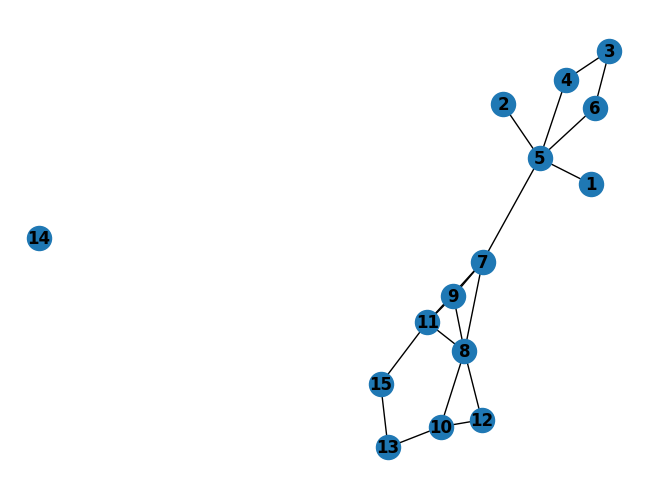

In [5]:
G = random_graph(15, 0.5, 4)
# draw a graph and show the plot
nx.draw(G, with_labels=True, font_weight='bold')
plt.show()

For a good visualization of a given solution we create a function to color the graph into two distinc colors. all nodes given in S will be shown in yellow, otherwise purple.

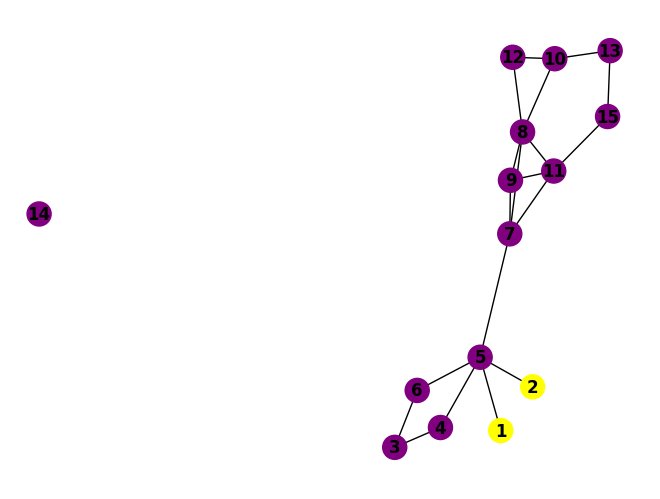

In [6]:
def show_colored_graph(G, S):

    colors = ["yellow" if i in S else "purple" for i in G.nodes]
    nx.draw(G, node_color=colors, with_labels=True, font_weight='bold')
    plt.show()

group1 = [1, 2]
show_colored_graph(G, group1)

#### maxcut cost function

Cost function computed for the Max Cut problem on the graph `G`, evaluated for the chosen set `S`.

$$
C_G(S) = n\left(\left\{\{u, v\} \in E: u \in S, v \notin S\right\}\right)
$$

In [7]:
def maxcut_costfunction(G, S):
    
    edges = G.edges
    cost = 0

    for i, j in edges:
        if i == j:
            continue
        if i in S and j not in S:
            cost += 1
        elif j in S and i not in S:
            cost += 1
    
    return cost

maxcut_costfunction(G, group1)

2

maxcut_initstate!(circuit[, qubits=nv(G)], G)
	
Appends to $circuit$ the state preparation for the Max Cut problem.
The initial state should be the ground state of the mixing hamiltonian with $\beta = 1$

$$
U_{\text{prep}} = \mathrm{e}^{-\imath \frac{\pi}{4} \sum_{i}^n Y_i}
$$

In [8]:
def maxcut_initstate(circ, G):
    circ.push(GateRY(pi/2), map(lambda x: x-1, G.nodes))

#### BitFlip mixer

Append to `circuit` a bitflip mixer with parameter `β`.

$$
U^H_M(\beta) = \mathrm{e}^{-\imath \beta B}
\qquad
B = \sum_{j=1}^n X_j
$$

In [9]:
def bitflip_mixer(circ, qubits, beta):
    circ.push(GateRX(2 * beta), qubits)

#### maxcut_phaseseparator

Appends to `circuit` the phase separator, with parameter `γ`, for the max cut problem defined on the graph `G`.

$$
U_P(\gamma) = \mathrm{e}^{-\imath \gamma H_P}
\qquad
H_P = -\sum_{\{u,v\} \in E} Z_u Z_v
$$
where ``Z_i`` is the pauli-Z rotation applied on qubit ``i`` and ``E`` is the set of edges of the graph.

In [10]:
def maxcut_phaseseparator(circ, G, gamma):
    for i, j in G.edges:
        circ.push(GateRZZ(-gamma), i -1, j-1)
    

#### maxcut_circuit

Constructs a `p`-step quantum algorithm for solving the max cut problem defined on the given graph.

The algorithm will consist of `p` repetitions of phase separators ([`maxcut_phaseseparator!`](@ref)) and mixers ([`maxcut_mixer!`](@ref)) with respectively increasing and decreasing parameters ($\gamma = \lambda$ and $\beta = 1-\lambda$ where $\lambda$ is a continuous monotonic increasing function of the step).

In [11]:
def maxcut_circuit(G, p):

    c = Circuit()
    maxcut_initstate(c, G)

    for i in range(1, p):
        lam = i / p
        gam = lam
        beta = (1 - lam)

        maxcut_phaseseparator(c, G, gam)

        bitflip_mixer(c, map(lambda x: x-1, G.nodes), beta)

    
    maxcut_phaseseparator(c, G, 1)
    return c
    

Execute the max cut problem defined for the given graph on MIMIQ remote services.
The algorithm will use `p` repetitions of mixers and phase separators.

In [12]:
def maxcut_execute(G, p):
	c = maxcut_circuit(G, p)
	sim = Quantanium()
	res = sim.execute(c)
	
	return res

res = maxcut_execute(G, 5)
res

QCSResults:
├── simulator: Quantanium StateVector 1.0
├── timings:
│    ├── apply time: 0.005003182s
│    └── sample time: 0.000460117s
├── fidelity estimate: 1
├── average multi-qubit gate error estimate: 0
├── most sampled:
│    ├── bs"001010011100001" => 12
│    ├── bs"110101100011100" => 10
│    ├── bs"110101110100011" => 10
│    ├── bs"110101101100001" => 8
│    └── bs"001010010011100" => 7
├── 1 executions
├── 0 amplitudes
└── 1000 samples

Here we define a few functions useful to observe the result sent back by mimiq

frozenbitarray('001010011100001')


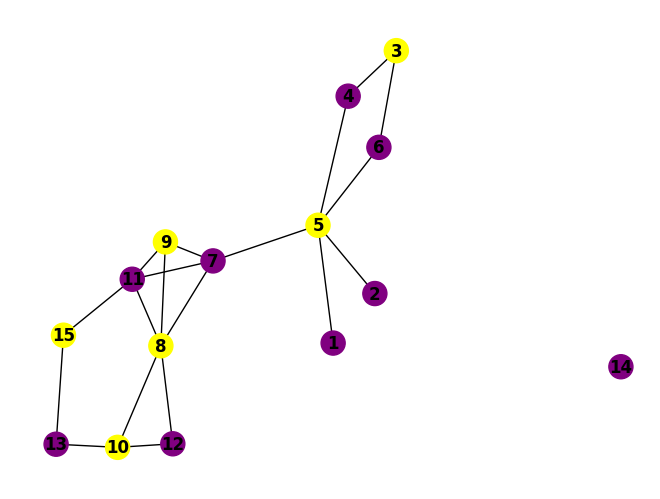

16

In [13]:
def get_most_common_result(results):
    hist = results.histogram()
    max_hist = max(hist, key=hist.get)
    print(max_hist)
    res = str(max_hist)[16:-2]
    return res


def evaluate_results(G, res):
    best_result = get_most_common_result(res)
    
    group1 = []
    for i in range(len(best_result)):
        if best_result[i] == '1':
            group1.append(i+1)

    show_colored_graph(G, group1)
    return maxcut_costfunction(G, group1)

evaluate_results(G, res)
